## Import

In [1]:
import os
#import json
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import decoupler as dc
import scanpy as sc
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

/home/rossi/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_path = "../phenotype_classification/output_phenotypes"

In [3]:
path = 'output'
output_path = os.path.join(path, 'excl_vs_ign')

## Load

In [4]:
adata = sc.read_h5ad(os.path.join(input_path, 'sc_phenotypes_unif_annotation.h5ad'))

In [5]:
phenotype_key = 'phenotype'
cell_type_key = 'celltype'
patient_key = 'patient_short'
tissue_region_key = 'tumor_source'

In [6]:
# exclude normal from analysis
adata_region = adata[adata.obs[tissue_region_key].isin(['core', 'border'])].copy()

In [7]:
# exclude phenotype ignored from analysis
adata = adata_region[adata_region.obs[phenotype_key].isin(['excluded', 'ignored'])].copy()

In [8]:
# raw counts for deseq2
adata.X = adata.layers['counts'].copy()

In [9]:
adata.obs[cell_type_key].value_counts()

celltype
Cancer cell         12729
Neutrophil           3875
T cell               3504
Plasma cell          2141
Macrophage           1172
Endothelial cell      642
B cell                592
Fibroblast            401
Dendritic cell        194
Epithelial cell       150
Mast cell             131
Schwann cell           13
Name: count, dtype: int64

## All cells

### Counts dataframe

In [10]:
adata.obs['patient_phenotype'] = (adata.obs[patient_key].astype(str) + " - " + adata.obs[phenotype_key].astype(str))
adata.obs['patient_phenotype'] = adata.obs['patient_phenotype'].astype('category')

counts_cancer = pd.DataFrame(adata.X.todense() if hasattr(adata.X, "todense") else adata_cancer.X, 
                             columns=adata.var['GeneSymbol'], 
                             index=adata.obs_names)

counts_cancer['patient_phenotype'] = adata.obs['patient_phenotype'].values
aggregated_counts = counts_cancer.groupby('patient_phenotype').sum()
aggregated_counts = aggregated_counts.astype(int)
aggregated_counts = aggregated_counts.groupby(level=0, axis=1).sum() # IMPORTANT: AGGREGATION OF DUPLICATED COLUMNS 

In [11]:
print(f"Genes: {aggregated_counts.shape[1]}")

# Filter out genes with low expression
# Keep genes with at least 10 counts in at least 3 patients
gene_keep = (aggregated_counts >= 10).sum(axis=0) >= 3
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes: 28434
Genes left: 14899


### Metadata dataframe

In [12]:
adata.obs[phenotype_key] = adata.obs[phenotype_key].astype('category')

metadata_cancer = adata.obs.set_index('patient_phenotype')[[patient_key, phenotype_key]]

aggregated_metadata = metadata_cancer[~metadata_cancer.index.duplicated(keep='first')] # sure it is the one and only met
aggregated_metadata = aggregated_metadata.sort_index()
for col in aggregated_metadata.columns:
    aggregated_metadata[col] = aggregated_metadata[col].astype('category')

### DeSeq2

In [13]:
inference = DefaultInference(n_cpus=96)
dds = DeseqDataSet(
    counts=aggregated_counts,
    metadata=aggregated_metadata,
    design_factors=['phenotype'],
    refit_cooks=True,
    inference=inference,
)

In [14]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.64 seconds.

Fitting dispersion trend curve...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 3.25 seconds.

Fitting LFCs...
... done in 2.14 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [183]:
#dds.write(os.path.join(path, 'deseq.h5ad'))

In [15]:
# default: alpha=0.05, cooks_filter=True, independent_filter=True
stat = DeseqStats(dds, contrast=["phenotype", 'excluded', 'ignored'], inference=inference)
stat.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: phenotype excluded vs ignored
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneSymbol                                                              
A1BG-AS1       7.568037        1.812094  3.255902  0.556557  0.577830   
A1CF        1465.959454        0.639241  0.593439  1.077182  0.281399   
A2M         1708.912370       -0.920661  0.451032 -2.041232  0.041228   
A4GALT        67.826661        0.424046  1.072044  0.395549  0.692438   
AAAS         650.322673        0.255457  0.316812  0.806335  0.420049   
...                 ...             ...       ...       ...       ...   
ZXDC         991.332399        0.038864  0.328093  0.118454  0.905708   
ZYG11B      1179.510655        0.198432  0.292654  0.678044  0.497744   
ZYX         1905.867054       -0.297671  0.412513 -0.721604  0.470538   
ZZEF1        663.279671        0.796493  0.490664  1.623297  0.104526   
ZZZ3        1461.555018        0.575586  0.228243  2.521

... done in 1.30 seconds.



In [16]:
results = stat.results_df

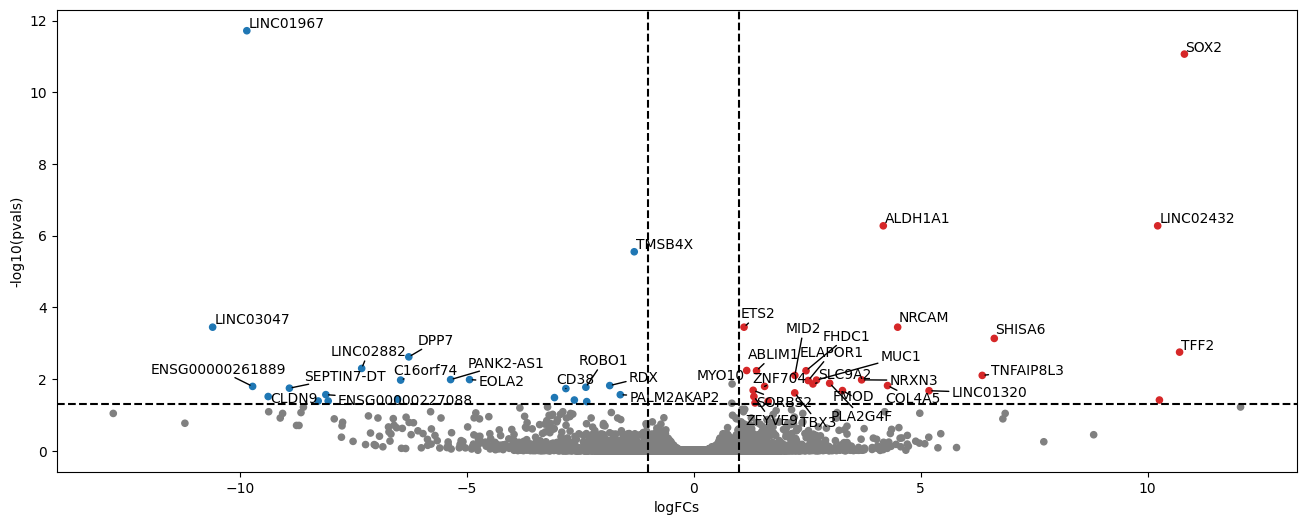

In [17]:
dc.plot_volcano_df(
    results,
    x='log2FoldChange', lFCs_thr=1,
    y='padj',
    top=40,
    figsize=(16, 6),
    #save='volcan_cancer.png'
)

In [18]:
results.to_csv(os.path.join(output_path, "de_results.csv"), index=True)